# Import Library

First of all, we'll import the libraries we want to use for this project in all.

In [1]:
# Import Required Python Packages :

import warnings
warnings.filterwarnings('ignore')
import os
import glob

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Scientific and Data manipulation libraries:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Keras for CNN model libraries:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.python.client import device_lib
from tensorflow.keras import regularizers

# Sklearn Libraries for train test split and classification report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import Data

Then we have to import the data we want to train and test which is the collection of weather images consist 11 categories of weathers and 6862 images of different types of weather. This data is from Kaggle, so you can acquire and check it by yourself if you interested, it can be used to implement weather classification based on the photo.

In [3]:
#Lets count all files and show subdirectory structure
totalFiles = 0
totalDir = 0
root_path = os.path.normpath('D:\Cindy\Final Project\weather-image\dataset')

for base, dirs, files in os.walk(root_path):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  D:\Cindy\Final Project\weather-image\dataset
Searching in :  D:\Cindy\Final Project\weather-image\dataset\dew
Searching in :  D:\Cindy\Final Project\weather-image\dataset\fogsmog
Searching in :  D:\Cindy\Final Project\weather-image\dataset\frost
Searching in :  D:\Cindy\Final Project\weather-image\dataset\glaze
Searching in :  D:\Cindy\Final Project\weather-image\dataset\hail
Searching in :  D:\Cindy\Final Project\weather-image\dataset\lightning
Searching in :  D:\Cindy\Final Project\weather-image\dataset\rain
Searching in :  D:\Cindy\Final Project\weather-image\dataset\rainbow
Searching in :  D:\Cindy\Final Project\weather-image\dataset\rime
Searching in :  D:\Cindy\Final Project\weather-image\dataset\sandstorm
Searching in :  D:\Cindy\Final Project\weather-image\dataset\snow
Total number of files 6862
Total Number of directories 11
Total: 6873


In [4]:
# put the image into dataframe using pandas
path_imgs = list(glob.glob(root_path+'/**/*.jpg'))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='Images').astype(str)
labels = pd.Series(labels, name='Labels')
df = pd.concat([file_path, labels], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

Images Labels
0  D:\Cindy\Final Project\weather-image\dataset\r...   rime
1  D:\Cindy\Final Project\weather-image\dataset\r...   rime
2  D:\Cindy\Final Project\weather-image\dataset\r...   rime
3  D:\Cindy\Final Project\weather-image\dataset\r...   rime
4  D:\Cindy\Final Project\weather-image\dataset\r...   rime

# Exploratory Data Analysis (EDA)

In Exploratory Data Analysis (EDA), since our goal is to classify the weather of the images, there is no need for extensive data cleaning processes like handling outliers, null values, and duplicates. We simpply need to showcase the following information:

1. The distribution of images across different weather categories,

2. The resolution of the images, including their height and width,

3. Samples of the weather images that we intend to classify using a CNN model.

## Plotting resolution (height and width) of the images

Before conducting Exploratory Data Analysis (EDA), I want to determine the resolution of these images so that I can find the average sizes (in pixels) of these weather images. Consistent image size is crucial for deep learning, mismatched matrices will bring your project to a quick stop. Visualizing raw image size can also help you understand your dataset better.

In [6]:
# Make a function to return the dimenstions for an RGB image, then just take the height and widht of it.
# Returns height resolutions for an RBG image
def get_dims_h(file):
    im = Image.open(file)
    arr = np.array(im)
    h = arr.shape[0]
    return h

# Returns width resolutions for an RBG image
def get_dims_w(file):
    im = Image.open(file)
    arr = np.array(im)
    w = arr.shape[1]
    return w

In [10]:
# Make a copy of the dataframe, just in case
df2 = df.copy()

# Next, apply the function to retrieve the height and width using a lambda within each row in the dataframe
df2['Height'] = df2.apply(lambda rows: get_dims_h(rows['Images']), axis=1)
df2['Width'] = df2.apply(lambda rows: get_dims_w(rows['Images']), axis=1)
df2

Images     Labels  Height  \
0     D:\Cindy\Final Project\weather-image\dataset\r...       rime     199   
1     D:\Cindy\Final Project\weather-image\dataset\r...       rime     266   
2     D:\Cindy\Final Project\weather-image\dataset\r...       rime     240   
3     D:\Cindy\Final Project\weather-image\dataset\r...       rime     231   
4     D:\Cindy\Final Project\weather-image\dataset\r...       rime     266   
...                                                 ...        ...     ...   
6857  D:\Cindy\Final Project\weather-image\dataset\r...       rime     400   
6858  D:\Cindy\Final Project\weather-image\dataset\s...  sandstorm     300   
6859  D:\Cindy\Final Project\weather-image\dataset\f...    fogsmog     240   
6860  D:\Cindy\Final Project\weather-image\dataset\d...        dew     588   
6861  D:\Cindy\Final Project\weather-image\dataset\s...       snow     450   

      Width  
0       300  
1       400  
2       455  
3       258  
4       400  
...     ...  
6857    300  
6858    400  
6859    431  
6860    980  
6861    800  

[6862 rows x 4 columns]

Text(0, 0.5, 'Height')

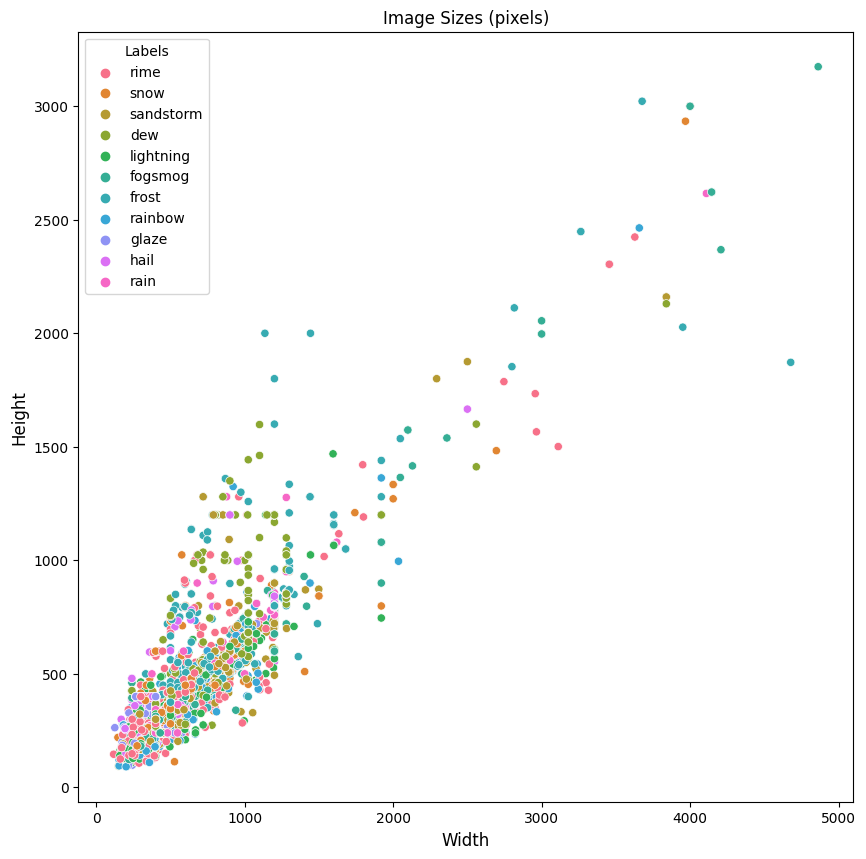

In [14]:
# plot width and height in one figure
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df2, x='Width',y='Height', hue='Labels')
plt.title('Image Sizes (pixels)') #Labeling titel
plt.xlabel('Width', fontsize=12) #Labeling x-axis 
plt.ylabel('Height', fontsize=12) #Labeling y-axis

From the images, we can conclude that the majority of these images have a resolution between 0 - 800 pixels.

## Pie Chart of the Images

Next, we plot the pie chart of all the images we have.

In [5]:
df_labels = df['Labels'].unique()
df_counts = df.Labels.value_counts()
fig = px.pie(names=df_labels, values=df_counts, title="Class Distribution")
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.update_layout({'title':{'x':1}})
fig.show()

We can see from the pie chart that, rime has the most images sample, next to it is snow, then sandstorm, dew, lightning, fogsmog, frost, rainbow, glaze, hail, and lastly rain.

## Bar plot

Next, we plot the bar plot of all the images and see the average of images.

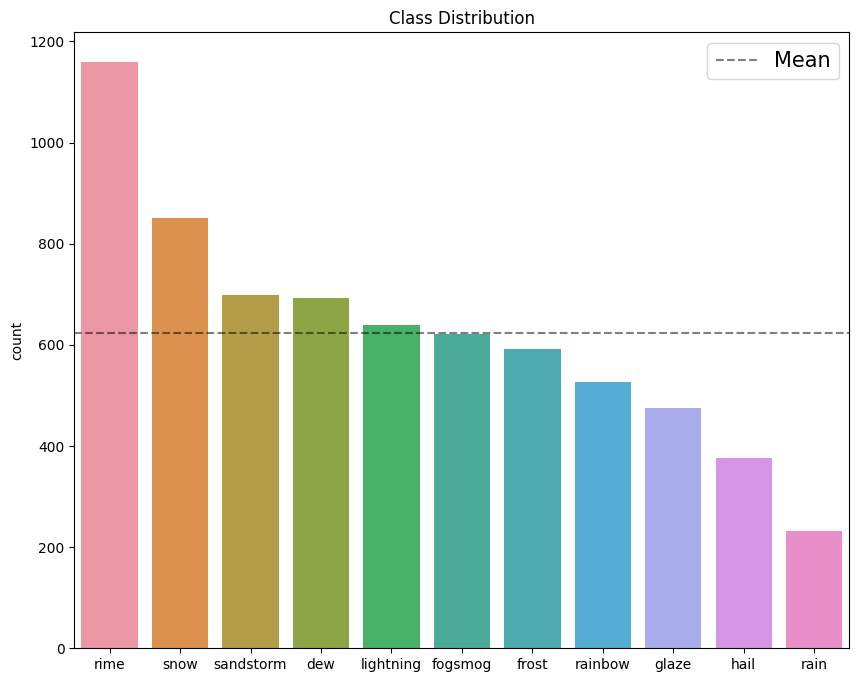

In [15]:
plt.figure(figsize=(10,8))
sns.barplot(x=df_labels, y=df_counts)
plt.axhline(np.mean(df_counts), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

We observe that the average number of total images falls between 600 and 650. This leads us to speculate that the model may exhibit a bias towards the left plot, which comprises categories like rime, snow, sandstorm, dew, and lightning due to the larger number of samples they have.

## Sample Images

Next, we will show the samples of the weather images we want to train into CNN model.

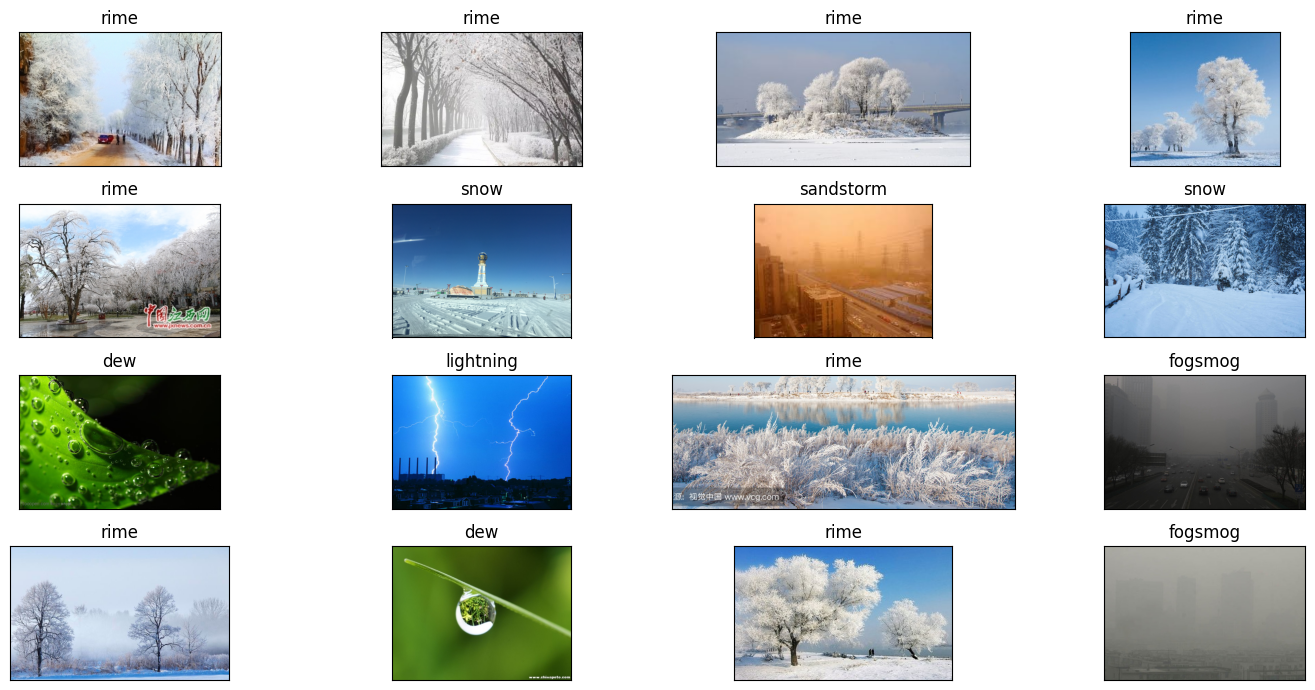

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Images[i]))
    ax.set_title(df.Labels[i])
plt.tight_layout()
plt.show()

# Train Test Split Data

After EDA, we will split the data into train and test data with 80% train and 20% test data

In [9]:
# Split dataframe into train and test with 80% train and 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)

# Image Processing and Data Augmentation

Finally we have reached into image processing. In this section we will do Data Augmentation for our dataframe before to make it easier to the images be processed in the model.

1. The batch size defines the number of samples that will be propagated through the network. We will stated that the batch size will be 32.
2. The image size is the size of the image will be put into the network. We put 256 pixels since mnost of our images reoslution between 0-1000.

Next, we'll definite image generator to generate our images with the preprocessing function follows the transfer learning model we'll use later, the train dataset will be splited into 2 data which consist train dataset 80% and validation dataset 20%.

One of the methods to prevent overfitting is to have more data. By this, our model will be exposed to more aspects of data and thus will generalize better. To get more data, either you manually collect data or generate data from the existing data by applying some transformations. The latter method is known as Data Augmentation.

1. rotation_range: This rotates each image up to the angle specified
2. shear_range: This is the shear angle in the counter-clockwise direction in degrees
3. zoom_range: This zooms the image. If passed as float then [lower, upper] = [1-zoom_range, 1+zoom_range]. For instance, 0.2 means zoom in the range [0.8, 1.2]. Can also be passed a list directly.
4. width_shift_range: This results in shifting the image in the horizontal direction.
5. height_shift_range: Similar to width_shift_range but in the vertical direction.
6. shuffle: Set True if you want to shuffle the order of the image that is being yielded
7. seed: Random seed for applying random image augmentation and shuffling the order of the image
8. horizontal_flip augmentation: a technique that flips an image horizontally, which means that the columns of pixels are reversed
9. fill_mode: nearest — Which will fill the area with the nearest pixel and stretching it
10. class_mode: categorical - cause we have more than 2 class output to predict.
11. color_mode: if the image is either black and white or grayscale set “grayscale” or if the image has three color channels, set “rgb”.

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

# make a function to generate image in the model later
def img_gen(pre_func, train, test):
    
    # Generate image using Keras Generator and also split the data train into train and data validation
    train_datagen = ImageDataGenerator(preprocessing_function=pre_func,validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre_func)
    
    # Flow training images in batches of 32 using train_datagen generator
    train_gen = train_datagen.flow_from_dataframe(
        dataframe = train,
        x_col='Images',
        y_col='Labels',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 100x100
        batch_size=BATCH_SIZE,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shuffle=True,
        seed=0,
        horizontal_flip=True,
        fill_mode="nearest",
        subset='training',
        class_mode='categorical')
    
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe = train,
        x_col='Images',
        y_col='Labels',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 100x100
        batch_size=BATCH_SIZE,
        rotation_range=30,
        shear_range=0.2,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shuffle=True,
        seed=0,
        horizontal_flip=True,
        fill_mode="nearest",
        subset='validation',
        class_mode='categorical')
    
    test_gen = test_datagen.flow_from_dataframe(
        dataframe = test,
        x_col='Images',
        y_col='Labels',
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 100x100
        batch_size=BATCH_SIZE,
        verbose=0,
        shuffle=False,
        color_mode='rgb',
        class_mode='categorical')
    
    return train_gen, valid_gen, test_gen

# Training the model

Then we will make a function to training the model with the transfer learning method later. Because we use the transfer learnin model so we don't have to make a model from the stracth, we just put the base model on the first then following:
1. Loading in a pre-trained model in keras and take layers from a previously trained model.
2. Freeze all layers in the base model by setting trainable = False, and train only the classifier (FC layers)
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train only the custom classifier layers for the task thereby optimizing the model for smaller dataset

Our custom classifier is the following layers: 
1. Batch normalization adds a ‘normalization layer’ after each convolutional layer. This allows the model to converge much faster in training and therefore also allows you to use higher learning rates.
2. Flatten works converting Matrix to single array,flattening is used to reduce the dimensionality of the input to a layer.
3. Fully connected with ReLU activation, shape = (inputs_shape, 100)
4. Dropout with 40% chance of dropping
5. Fully connected with ReLU activation, shape = (inputs_shape, 100)
6. Dropout with 20% chance of dropping
7. Fully connected with log softmax output.

Then compile the model with these parameter:
1. CategoricalCrossentropy is a measure of how different the predicted labels are from the true labels. The function is commonly used in deep learning models that use softmax activation in the output layer.
2. The Adam optimizer, short for “Adaptive Moment Estimation,” is an iterative optimization algorithm used to minimize the loss function during the training of neural networks.
3. Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect to the loss gradient. High learning rates increase the risk of losing previous knowledge because higher the learning rate more changes with the learnt weights (pretrained) and so it’s smart to use a small learning rate.

Then we will use Early stopping, Early stopping means halting training when the validation loss has not decreased for a number of epochs. As we continue training, the training loss will only decrease, but the validation loss will eventually reach a minimum and plateau or start to increase. We ideally want to stop training when the validation loss is at a minimum in the hope that this model will generalize best to the testing data. The parameter we use in early stopping is:
1. min_delta : minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
2. patience : number of epochs with no improvement after which training will be stopped.et.

In [17]:
from tensorflow.keras import regularizers

def func(name_model):
    # Create base model
    pre_model = name_model(input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    # Freeze base model
    pre_model.trainable = False
    # Create new model on top.
    x = pre_model.output
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = keras.layers.Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(rate=0.4, seed=123)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(rate=0.2, seed=123)(x)
    outputs = Dense(11, activation='softmax')(x)
    model = Model(inputs=pre_model.input, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
    return model, my_callbacks

Next, we will generate plots depicting accuracy versus validation accuracy, as well as loss versus validation loss. Following this, we will employ the pre-compiled model to make predictions on the test data. Subsequently, we will print the classification report for the test model and display samples of the predicted images.

In [12]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
        
    # Predict Data Test
    pred = model.predict(test_gen)
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Images.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

Finally, we'll print the test loss and test accuracy of the model.

In [13]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    
    print("    Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

After this, we'll split the model into two different scenarios. First, we'll create the model from scratch, and second, we'll use the transfer learning model.

## Model from Scratch

In this section, we'll try to build the model from scratch. The parameters will be set the same as above

In [38]:
# Generate image using Keras Generator and also split the data train into train and data validation
train_datagen = ImageDataGenerator(
    validation_split=0.2)
test_datagen = ImageDataGenerator()

In [39]:
train_gen_model = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col='Images',
    y_col='Labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 100x100
    batch_size=BATCH_SIZE,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest",
    subset='training',
    class_mode='categorical')
    
valid_gen_model = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col='Images',
    y_col='Labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 100x100
    batch_size=BATCH_SIZE,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shuffle=False,
    seed=0,
    horizontal_flip=True,
    fill_mode="nearest",
    subset='validation',
    class_mode='categorical')
    
test_gen_model = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    x_col='Images',
    y_col='Labels',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 100x100
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.


These is following layer we created:
1. Convolutional Layer: In a typical neural network each input neuron is connected to the next hidden layer. In CNN, only a small region of the input layer neurons connect to the neuron hidden layer.
2. Pooling Layer: The pooling layer is used to reduce the dimensionality of the feature map. There will be multiple activation & pooling layers inside the hidden layer of the CNN.
3. Fully-Connected layer: Fully Connected Layers form the last few layers in the network. The input to the fully connected layer is the output from the final Pooling or Convolutional Layer, which is flattened and then fed into the fully connected layer.

In [40]:
keras.backend.clear_session() #clear model numbers

input_layer = keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))

#CNN - Convolutional Layers - Block1
conv_layer = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
conv_layer = keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(conv_layer)
pooling_layer = keras.layers.MaxPool2D(pool_size=(2,2))(conv_layer)
norm = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)((pooling_layer))

#FC - Fully connected
flatten = keras.layers.Flatten()(norm)
dense = keras.layers.Dense(100, activation="relu")(flatten)
dropout = keras.layers.Dropout(0.4)(dense)
dense = keras.layers.Dense(100, activation="relu")(dropout)
dropout = keras.layers.Dropout(0.2)(dense)

classifier = keras.layers.Dense(11, activation="softmax")(dropout)

model = keras.Model(inputs=input_layer, outputs=classifier)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      4624      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 262144)            0     

In [ ]:
history_model = model.fit(train_gen_model,
                          validation_data=valid_gen_model,
                          epochs=10,
                          verbose=1)

Epoch 1/10
138/138 [==============================] - 427s 3s/step - loss: 2.1335 - accuracy: 0.3292 - val_loss: 1.9494 - val_accuracy: 0.3719
Epoch 2/10
138/138 [==============================] - 392s 3s/step - loss: 2.0057 - accuracy: 0.3748 - val_loss: 1.8578 - val_accuracy: 0.4348
Epoch 3/10
138/138 [==============================] - 386s 3s/step - loss: 1.8920 - accuracy: 0.4283 - val_loss: 1.6699 - val_accuracy: 0.4840
Epoch 4/10
138/138 [==============================] - 384s 3s/step - loss: 1.7944 - accuracy: 0.4454 - val_loss: 1.7215 - val_accuracy: 0.5232
Epoch 5/10
138/138 [==============================] - 378s 3s/step - loss: 1.6813 - accuracy: 0.4613 - val_loss: 1.7802 - val_accuracy: 0.4868
Epoch 6/10
138/138 [==============================] - 377s 3s/step - loss: 1.5676 - accuracy: 0.4989 - val_loss: 1.6704 - val_accuracy: 0.5406
Epoch 7/10
138/138 [==============================] - 512s 4s/step - loss: 1.4828 - accuracy: 0.5194 - val_loss: 1.3704 - val_accuracy: 0.5816

1. "loss" refers to the loss value over the training data after each epoch. This is what the optimization process is trying to minimize with the training so, the lower, the better.
2. "accuracy" refers to the ratio between correct predictions and the total number of predictions in the training data. The higher, the better.
The "validation" counterparts are the same concepts but computed over the validation data, which is not used for training and hence "unseen" to your model. If the training loss and accuracy are good but the validation counterparts are bad, it means that your model is "overfitting", as it can't generalize to unseen data.

In this section I decide to stop the epoch because the limit time I have, but we can already see that the accuracy doesn't improving even at epoch 8. So we can conclude that this model just have the accuracy of 54% which is bad for our model. These low accuracy can be caused by:
1. We need more layer in CNN.
2. Try to rescaling the image and find the right amount.
3. Try to put more epoch into the training.
4. Adjust the batch and learning rate.

In [ ]:
history=plot(history_model,test_gen_model,train_gen_model, model)
result_model = result_test(test_gen_model,model)

## Transfer Learning Model

Transfer learning is a technique in machine learning where a model trained on one task is used as a starting point for another task. In the context of convolutional neural networks (CNNs), transfer learning involves using a pre-trained CNN model as a starting point for a new CNN model. The pre-trained model is typically trained on a large dataset, such as ImageNet, and has learned to recognize many features of images. By using the pre-trained model as a starting point, the new model can be trained on a smaller dataset with less computational resources and still achieve high accuracy.

The basic premise of transfer learning is simple: take a model trained on a large dataset and transfer its knowledge to a smaller dataset. Transfer learning can be implemented using the Keras library in Python. The pre-trained models available in Keras can be found on the Keras Applications. These models were trained on the ImageNet classification problem and can be used directly. The accuracy of these models as well as the parameters they have used can be seen on the same page. The depth of the models are shown as well.

Why Transfer Learning for CNN?
1. Generally very few people train a Convolution network from scratch (random initialisation) because it is very rare to get enough dataset. So, mostly we use use pre-trained network weights as initialisations for solving most of the problems in hand.
2. Very Deep Networks are expensive to train. The most complex models take weeks to train using hundreds of machines equipped with expensive GPUs.

In this section we'll use 4 kinds of transfer learning:
1. MobileNet
2. VGG16
3. ResNet50
4. EfficientNet

### MobileNet

MobileNet is a computer vision model open-sourced by Google and designed for training classifiers. It uses depthwise convolutions (Depth convolution and point convolution) to significantly reduce the number of parameters compared to other networks, resulting in a lightweight deep neural network. MobileNet is Tensorflow’s first mobile computer vision model.

In this section we'll import MobileNet and put it into the fuction of model we created before to predict.

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
17225924/17225924 [==============================] - 44s 3us/step
Epoch 1/10
138/138 [==============================] - 139s 994ms/step - loss: 1.1793 - accuracy: 0.6097 - val_loss: 0.5092 - val_accuracy: 0.8241
Epoch 2/10
138/138 [==============================] - 92s 668ms/step - loss: 0.5771 - accuracy: 0.8165 - val_loss: 0.4000 - val_accuracy: 0.8633
Epoch 3/10
138/138 [==============================] - 103s 743ms/step - loss: 0.4849 - accuracy: 0.8413 - val_loss: 0.3632 - val_accuracy: 0.8806
Epoch 4/10
138/138 [==============================] - 98s 707ms/step - loss: 0.3685 - accuracy: 0.8718 - val_loss: 0.3420 - val_accuracy: 0.8915
Epoch 5/10
138/138 [==============================] - 100s 724ms/step - loss: 0.2986 - accuracy: 0.9010 - val_loss: 0.3542 - val_accuracy: 0.8943
Epoch 6/10
43/43 [==

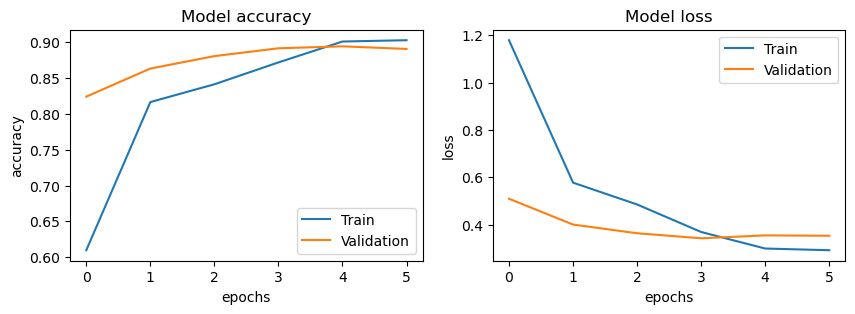

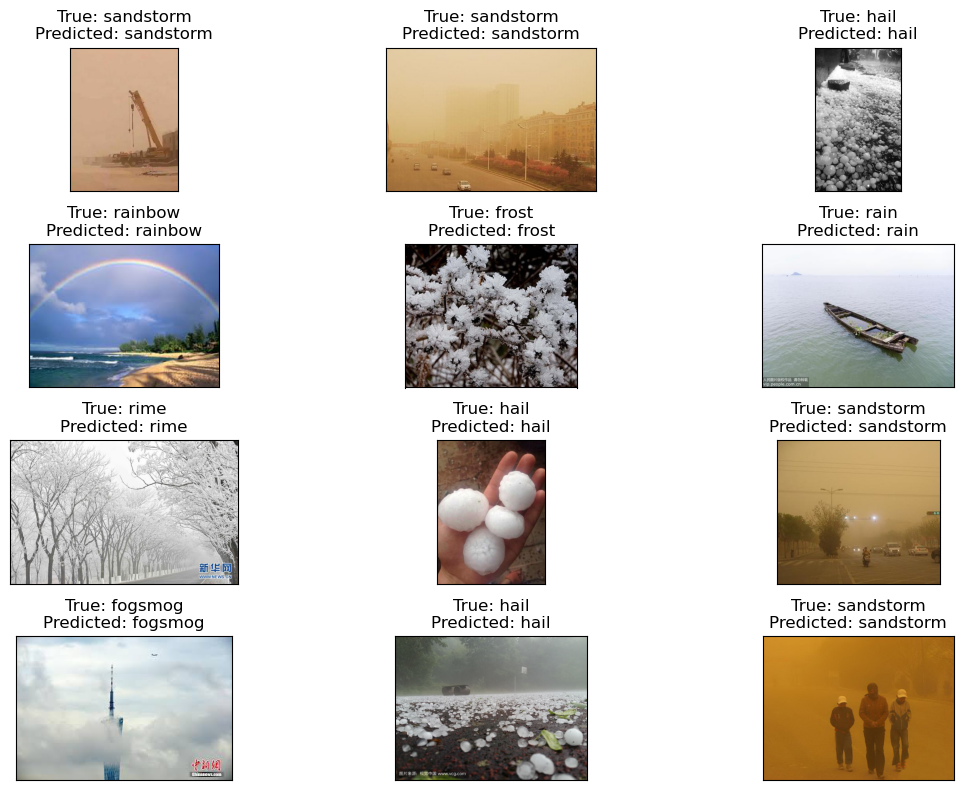

    Test Loss: 0.35040
Test Accuracy: 88.93%


In [19]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_MobileNet, valid_gen_MobileNet, test_gen_MobileNet = img_gen(MobileNet_pre,train_df,test_df)
MobileNet_model, callback=func(MobileNet)
history = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=10,
    callbacks=callback,
    verbose=1
)
history_MobileNet = plot(history,test_gen_MobileNet,train_gen_MobileNet, MobileNet_model)

result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)

### VGG16

VGG16 refers to the VGG model, also called VGGNet. It is a convolution neural network (CNN) model supporting 16 layers. VGG16 is thus a relatively extensive network with a total of 138 million parameters—it’s huge even by today’s standards. However, the simplicity of the VGGNet16 architecture is its main attraction. It Only has Conv and pooling layers in it, always use a 3 x 3 Kernel for convolution and 
2x2 size of the max poo.l


In this section we'll import VGG16 and put it into the fuction of model we created before to predict.

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
58889256/58889256 [==============================] - 910s 15us/step
Epoch 1/10
138/138 [==============================] - 1671s 12s/step - loss: 1.4720 - accuracy: 0.5194 - val_loss: 0.6720 - val_accuracy: 0.7776
Epoch 2/10
138/138 [==============================] - 862s 6s/step - loss: 0.7759 - accuracy: 0.7445 - val_loss: 0.5200 - val_accuracy: 0.8213
Epoch 3/10
138/138 [==============================] - 858s 6s/step - loss: 0.6315 - accuracy: 0.7851 - val_loss: 0.4733 - val_accuracy: 0.8441
Epoch 4/10
138/138 [==============================] - 865s 6s/step - loss: 0.5309 - accuracy: 0.8172 - val_loss: 0.4443 - val_accuracy: 0.8560
Epoch 5/10
138/138 [==============================] - 844s 6s/step - loss: 0.4900 - accuracy: 0.8258 - val_loss: 0.4538 - val_accuracy: 0.8532
Epoch 6/10
138/138 [=========

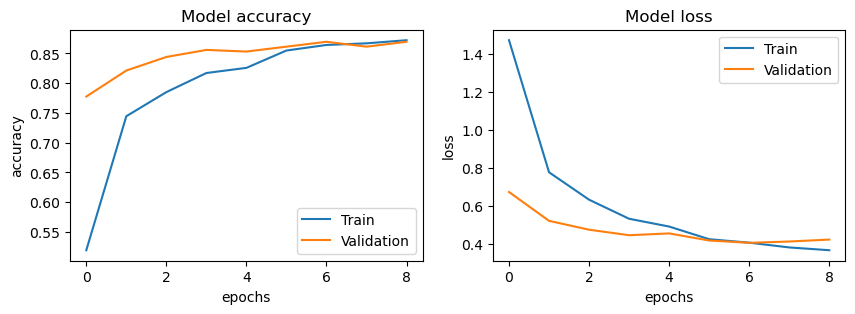

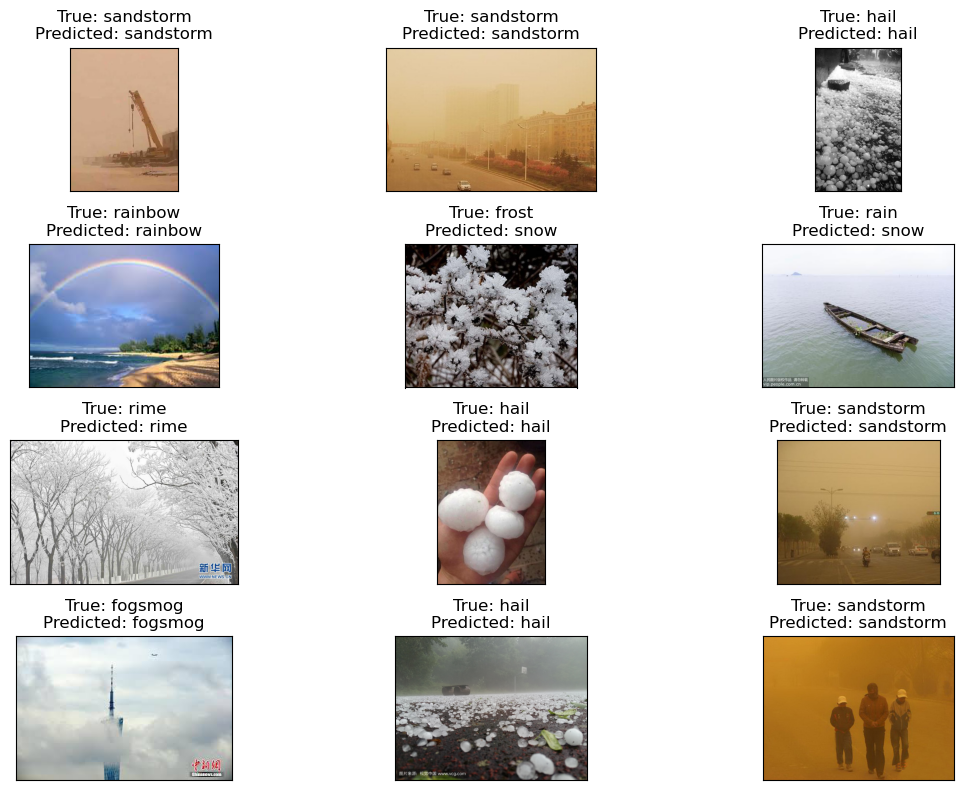

    Test Loss: 0.42179
Test Accuracy: 85.94%


In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg_pre=preprocess_input
train_gen_VGG, valid_gen_VGG, test_gen_VGG = img_gen(vgg_pre,train_df,test_df)
model_VGG16, callback=func(VGG16)
history = model_VGG16.fit(
    train_gen_VGG,
    validation_data=valid_gen_VGG,
    epochs=10,
    callbacks=callback,
    verbose=1
)
history=plot(history,test_gen_VGG,train_gen_VGG, model_VGG16)
result_VGG16 = result_test(test_gen_VGG,model_VGG16)

### ResNet50

ResNet stands for Residual Network and is a specific type of convolutional neural network (CNN). ResNet-50 is a 50-layer convolutional neural network (48 convolutional layers, one MaxPool layer, and one average pool layer). Residual neural networks are a type of artificial neural network (ANN) that forms networks by stacking residual blocks.k/

In this section we'll import ResNet50 and put it into the fuction of model we created before to predict.

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
Epoch 1/10
138/138 [==============================] - 354s 3s/step - loss: 1.0257 - accuracy: 0.6671 - val_loss: 0.4387 - val_accuracy: 0.8687
Epoch 2/10
138/138 [==============================] - 352s 3s/step - loss: 0.5351 - accuracy: 0.8238 - val_loss: 0.3751 - val_accuracy: 0.8742
Epoch 3/10
138/138 [==============================] - 345s 2s/step - loss: 0.4310 - accuracy: 0.8538 - val_loss: 0.3523 - val_accuracy: 0.8915
Epoch 4/10
138/138 [==============================] - 350s 3s/step - loss: 0.3486 - accuracy: 0.8823 - val_loss: 0.3702 - val_accuracy: 0.8851
Epoch 5/10
43/43 [==============================] - 85s 2s/step
              precision    recall  f1-score   support

         dew       0.97      0.96      0.96       140
     fogsmog       0.86      0.95      0.90       160
       frost   

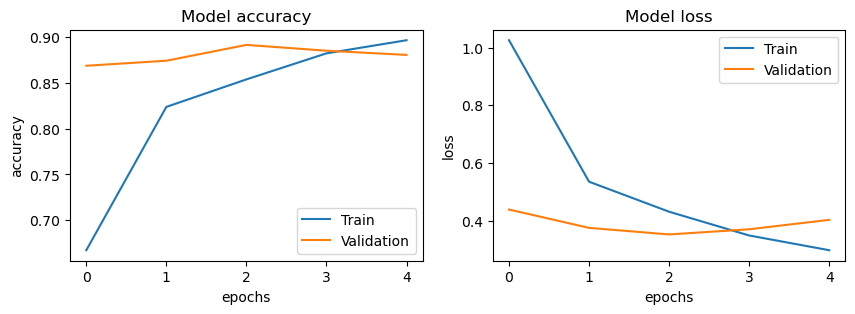

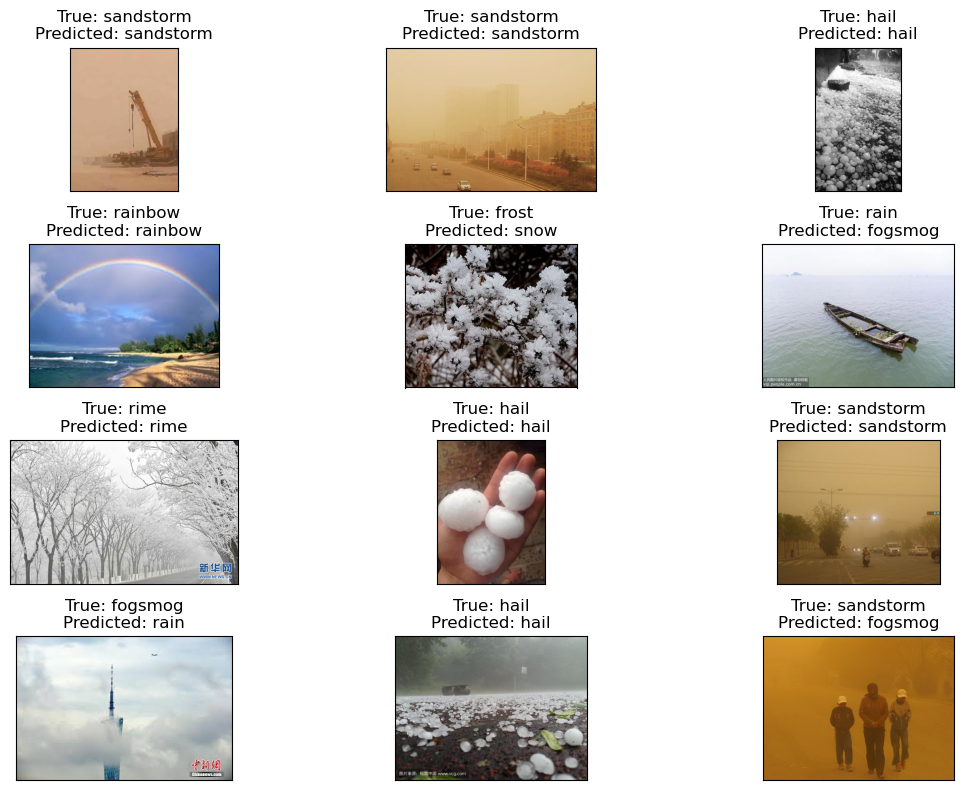

    Test Loss: 0.30393
Test Accuracy: 89.80%


In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet_pre=preprocess_input
train_gen_ResNet, valid_gen_ResNet, test_gen_ResNet = img_gen(ResNet_pre,train_df,test_df)
ResNet_model, callback=func(ResNet50)
history = ResNet_model.fit(
    train_gen_ResNet,
    validation_data=valid_gen_ResNet,
    epochs=10,
    callbacks=callback,
    verbose=1
)

history_ResNet= plot(history,test_gen_ResNet,train_gen_ResNet, ResNet_model)

result_ResNet = result_test(test_gen_ResNet,ResNet_model)

### EfficientNet

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients.

EfficientNet B7 is a convolutional neural network (CNN) architecture that was developed by Google researchers in 2019. It is currently considered one of the most powerful CNN architectures available.

In this section we'll import EfficientNetB7 and put it into the fuction of model we created before to predict.1.

Found 4392 validated image filenames belonging to 11 classes.
Found 1097 validated image filenames belonging to 11 classes.
Found 1373 validated image filenames belonging to 11 classes.
258076736/258076736 [==============================] - 65s 0us/step
Epoch 1/10
138/138 [==============================] - 1243s 9s/step - loss: 1.1543 - accuracy: 0.6318 - val_loss: 0.8914 - val_accuracy: 0.8095
Epoch 2/10
138/138 [==============================] - 1224s 9s/step - loss: 0.7243 - accuracy: 0.7637 - val_loss: 0.5540 - val_accuracy: 0.8350
Epoch 3/10
138/138 [==============================] - 1247s 9s/step - loss: 0.6127 - accuracy: 0.7930 - val_loss: 0.4722 - val_accuracy: 0.8487
Epoch 4/10
138/138 [==============================] - 1218s 9s/step - loss: 0.5488 - accuracy: 0.8142 - val_loss: 0.4867 - val_accuracy: 0.8487
Epoch 5/10
43/43 [==============================] - 309s 7s/step
              precision    recall  f1-score   support

         dew       0.95      0.94      0.95       

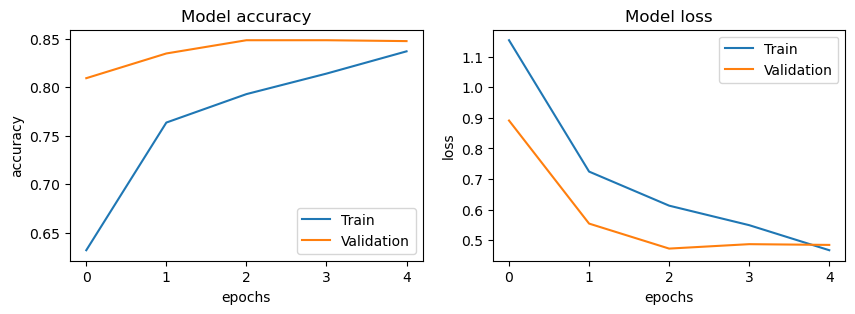

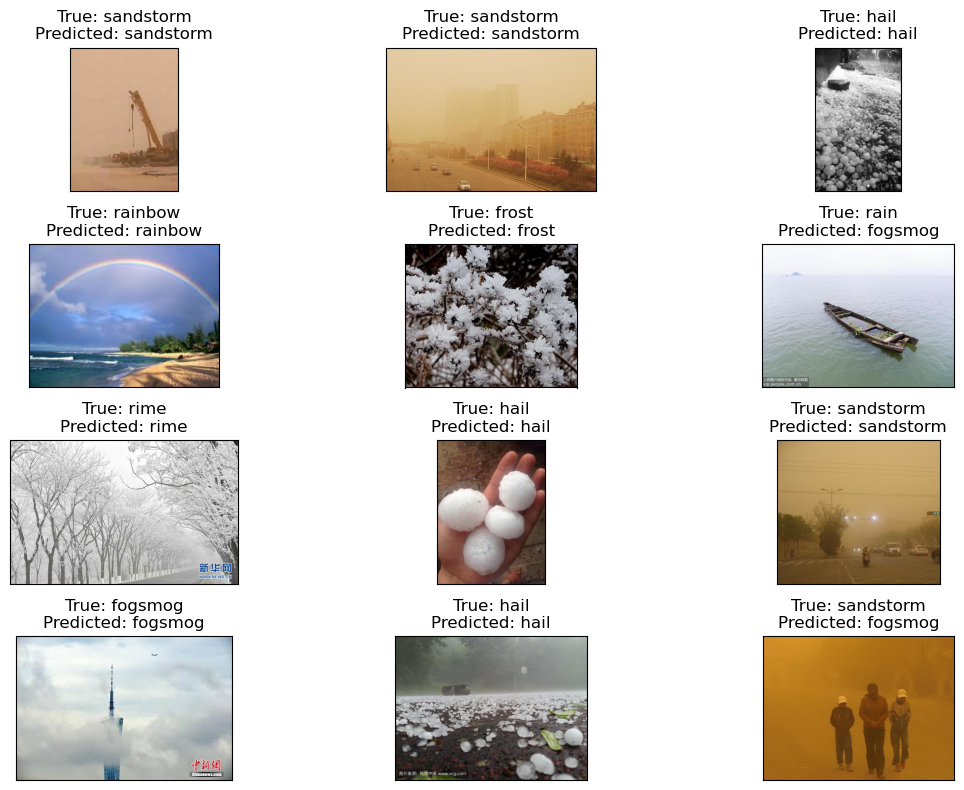

    Test Loss: 0.42201
Test Accuracy: 86.38%


In [28]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

ENet_pre=preprocess_input
train_gen_ENet, valid_gen_ENet, test_gen_ENet = img_gen(ENet_pre,train_df,test_df)
ENet_model, callback=func(EfficientNetB7)
history = ENet_model.fit(
    train_gen_ENet,
    validation_data=valid_gen_ENet,
    epochs=10,
    callbacks=callback,
    verbose=1
)
history_ENet=plot(history,test_gen_ENet,train_gen_ENet, ENet_model)

result_ENet = result_test(test_gen_ENet,ENet_model)

# Model Result & Conclusion

After all of these models predict, finally, we'll compare them with each other to see which one has the best accuracy.

In [33]:
result = pd.DataFrame({'Model':['MobileNet','VGG16','ResNet50','EfficientNetB7'],
                      'Accuracy':[result_MobileNet[1], result_VGG16[1], result_ResNet[1], result_ENet[1]]})
result.head()
result.to_csv('compare.csv')

In [32]:
fig = px.bar(result, x='Model', y='Accuracy', title = 'Accuracy Result')
fig.update_layout(
    autosize=False,
    width=500,
    height=400,)
fig.update_layout({'title':{'x':1}})
fig.show()

From the above graphic, we can see that ResNet50 has the highest accuracy among all the models we have used. Moreover, we observe that the accuracy among the four models is not significantly different.
Through this project, we were able to see the basics of using Keras as well as the concept of transfer learning, an effective method for object recognition. Before we try to training a model from scratch, however we obtained poor accuracy. Afterwards, we tried using the existing architectures that have been trained on a large dataset and then tune them for our task. This reduces the time to train and often results in better overall performance. The outcome of this project is to try the Deep learning model to classify weather images with CNN and some knowledge of transfer learning with Keras that we can build on to build more complex applications.


There are various ways to improve accuracy, so you can try them by yourself. The creator's best advice is to always adjust the hyperparameters, as they are crucial to the model's performan and to add number of epoch.e
